# **Time Series Data for rainfall**

**Name:** Arjun Adhikari
          
**Date:** 17th June, 2024. 

Third year Civil Engineering Student at Pulchowk Campus

I downloaded the zip file 2, extracted it, and opened the shapefile in QGIS, discovered it to be point data. I didn’t know much about Google Earth Engine, but my respected teacher, Dr. Prem Chandra Jha, had once mentioned it. While working on Task 2, I found that it was related to Google Earth Engine, which level up my interest.

I explored the documentation and was fascinated by Google Earth Engine. It became even more interesting when I realized we could import Earth Engine into a Python console. I tried to learn from the documentation and attempted to extract the data but encountered some errors. I then sought help from ChatGPT and proceeded as follows:

Please verify my results.

Lets Import necessary library

In [1]:
import ee
import geopandas as gpd
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import folium

Lets initialize Earth Engine API

In [2]:
ee.Initialize() 

Loading the Shapefile and Extracting Location

In [3]:
gdf = gpd.read_file("location point.shp")
point = gdf.geometry.iloc[0]
location = ee.Geometry.Point(point.x, point.y)

Lets visualize our area of interest

In [4]:
# Create a map centered around the location point
m = folium.Map(location=[point.y, point.x], zoom_start=10)

In [5]:
m

## **Define a Function to Extract Precipitation Data:**

In [6]:
def extract_precipitation(image):
    date = image.date().format('YYYY-MM-dd')
    precipitation = image.reduceRegion(ee.Reducer.first(), location, scale=1000).get('precipitationCal')
    return ee.Feature(None, {'date': date, 'precipitation': precipitation})


load the GPM IMERG dataset (NASA/GPM_L3/IMERG_V06) into an ImageCollection.
Filter the dataset to include only the images within the specified date range.
Select the precipitationCal band, which contains the precipitation data.


In [7]:
def get_precipitation_data(start_date, end_date):
    dataset = ee.ImageCollection('NASA/GPM_L3/IMERG_V06') \
                .filterDate(start_date, end_date) \
                .select('precipitationCal')
    precipitation_data = dataset.map(extract_precipitation)
    return precipitation_data.getInfo()['features']


## **Batch Processing Function**

In order to divide the time range into smaller batches (in this case, 30 days) such that each batch process seperately and avoids time outs, lets make batch processing function

In [8]:
def batch_process(start_date, end_date, batch_size_days=30):
    current_start_date = datetime.strptime(start_date, '%Y-%m-%d')
    final_end_date = datetime.strptime(end_date, '%Y-%m-%d')
    batch_size = timedelta(days=batch_size_days)
    all_data = []

    while current_start_date < final_end_date:
        current_end_date = min(current_start_date + batch_size, final_end_date)
        data_batch = get_precipitation_data(current_start_date.strftime('%Y-%m-%d'), current_end_date.strftime('%Y-%m-%d'))
        all_data.extend(data_batch)
        current_start_date = current_end_date

    return all_data


In [9]:
# Define the time period
start_date = '2019-01-01'
end_date = '2020-12-31'
batch_size_days = 30  # Process data in 30-day batches

# Process the data in batches
all_data = batch_process(start_date, end_date, batch_size_days)

# Convert the data to a Pandas DataFrame
data = [{'date': feature['properties']['date'], 'precipitation': feature['properties']['precipitation']} for feature in all_data]
df = pd.DataFrame(data)

# Convert the date to datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort the DataFrame by date
df = df.sort_values('date').reset_index(drop=True)

# Save the DataFrame to a CSV file
df.to_csv('rainfalltimeseries.csv', index=False)



In [10]:
df

,date,precipitation
0,2019-01-01,0.0
1,2019-01-01,0.0
2,2019-01-01,0.0
3,2019-01-01,0.0
4,2019-01-01,0.0
...,...,...
35035,2020-12-30,0.0
35036,2020-12-30,0.0
35037,2020-12-30,0.0
35038,2020-12-30,0.0


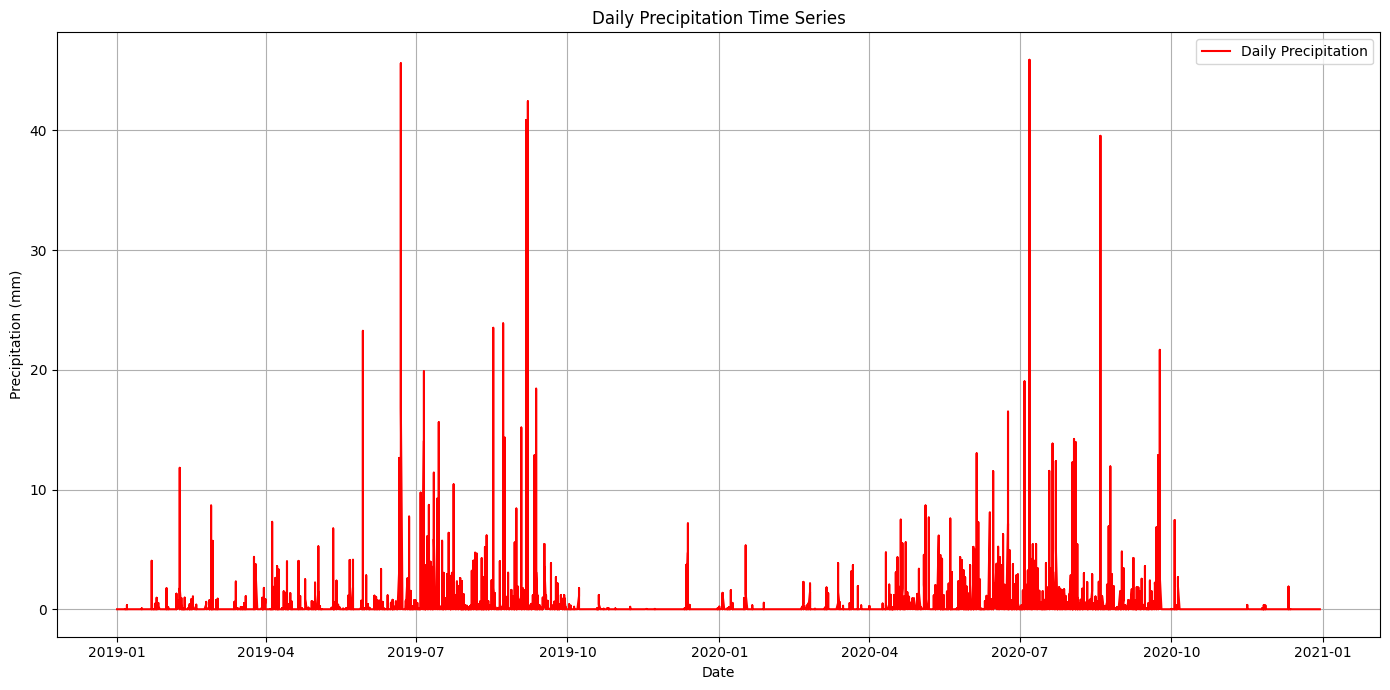

In [11]:
# Plotting the data
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['precipitation'], label='Daily Precipitation', color='r')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.title('Daily Precipitation Time Series')
plt.legend()
plt.grid(True)
plt.tight_layout()

## **Conclusion**

This dataset comprises two years of rainfall data (time series). By analyzing a larger dataset spanning multiple years, we can identify patterns, create training sets, and utilize machine learning models such as scikit-learn or Keras to forecast future rainfall.

## **References**

Google. (n.d.). Introduction to the Earth Engine Python API. Retrieved from 
https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api

OpenAI. (2024). ChatGPT. Retrieved from https://www.openai.com/chatgpt